# Setup

In [1]:
DATA_VERSION = "2025-07-21"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
DOCUMENT_EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)
CONSULTATION_EMBEDDINGS_FILE_NAME = (
    f"consultation-attributes-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)


LANGUAGES = {
    "de",
    # "fr",
    # "it",
}
TOPIC_LABEL_SOURCES = {
    # "openparldata",
    # "organisation_rule",
    "manual",
}

# FROM_YEAR = 2010
FROM_YEAR = 2000

MIN_CONSULTATIONS_IN_CLASS = 40

_approximate_topic_f1_scores = {
    "administration": 0.593,
    "agriculture": 0.809,
    "communications": 0.739,
    "culture": 0.677,
    "defense": 0.675,
    "economics": 0.585,
    "education": 0.854,
    "energy": 0.921,
    "environment": 0.763,
    "finance": 0.657,
    "foreign_policy": 0.675,
    "health": 0.816,
    "housing": 0.79,
    "insurance": 0.925,
    "it": 0.697,
    "law": 0.603,
    "migration": 0.847,
    "political_system": 0.805,
    "public_finance": 0.75,
    "science": 0.634,
    "security": 0.609,
    "social": 0.576,
    "spatial_planning": 0.663,
    "sports": 0.875,
    "transportation": 0.888,
}

IGNORE_TOPICS = {t for t, f1 in _approximate_topic_f1_scores.items() if f1 < 0.8}

DOC_TYPES = {
    "DRAFT",
    # None,  # Many openparldata documents don't have a known type
    # "VARIOUS_TEXT",
    "LETTER",
    # "RECIPIENT_LIST",  # proven to not be useful
    "REPORT",
    "FINAL_REPORT",
    # "OPINION",
    # "SYNOPTIC_TABLE",  # possibly not useful?
    # "SURVEY",
    # "RESPONSE_FORM",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 2712

In [2]:
%load_ext autoreload
%autoreload 2

import functools
import pathlib
import sys
from typing import Any

import dotenv
import iterstrat.ml_stratifiers
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.pipeline import Pipeline
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
import demokratis_ml.models.consultation_topics.model
import demokratis_ml.models.consultation_topics.preprocessing
from research.lib import data_access, plotting, utils

In [4]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_consultation_topic_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("document_embeddings_file", DOCUMENT_EMBEDDINGS_FILE_NAME)
mlflow.log_param("consultation_embeddings_file", CONSULTATION_EMBEDDINGS_FILE_NAME)
mlflow.log_param("topic_label_sources", sorted(TOPIC_LABEL_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("min_consultations_in_class", MIN_CONSULTATIONS_IN_CLASS)
mlflow.log_param("ignore_topics", sorted(IGNORE_TOPICS))
mlflow.log_param("doc_types", sorted(map(str, DOC_TYPES)))
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = magnificent-shark-41


''

In [5]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/07/24 16:07:46 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [6]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)
DOCUMENT_EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DOCUMENT_EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(DOCUMENT_EMBEDDINGS_DATA_FILE)
CONSULTATION_EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / CONSULTATION_EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(CONSULTATION_EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-07-21.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-07-21.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-attributes-embeddings-beginnings-openai-text-embedding-3-large-2025-07-21.parquet already exists locally.


In [7]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_languages=LANGUAGES,
    only_doc_types=DOC_TYPES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_docs = df_docs[df_docs["consultation_topics_label_source"].isin(TOPIC_LABEL_SOURCES)]
df_docs

,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_uuid,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wffQLMxGCHhjJ6PKmR,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
6,1CAJoURQMxKeqCdQ564eYH,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfjrEEFeu6PDxuCd16,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb
9,1CAJoURQbi5gxw7Wp5N5rT,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfmiLy7uCJJK4xiJ4o,fedlex,manual,fedlex,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
12,1CAJoURQbi5gxw7WpL8ns1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfoMZEhmu1hg9dvJGj,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9
18,1CAJoURQbi5gxw7Wpjj86f,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wg4pF6iCrNJakW9ic5,fedlex,manual,fedlex,Juni 2022 \nErgebnisbericht \nVernehmlassung z...,2024/1/19/1CM3wg4ojv3tDHAp4z8yVV.pdf,application/pdf,a69ffad450d4be79e8f92c1d43a00792c290ea40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53999,1CQZt3r1yo2EftH4EM6vP6,j8j9vmyc,2025-06-26,2025-10-31,Änderung des Kantonalen Energiegesetzes vom Ju...,Der vorliegende Vernehmlassungsentwurf legt de...,https://www.lu.ch/-/media/Kanton/Dokumente/BUW...,https://www.demokratis.ch/vernehmlassung/j8j9vmyc,"[energy, environment, housing]","[{'created_at': 2025-06-30 09:50:50, 'name': '...",...,Regierungsrat des Kantons Luzern,lu,1CQdqaqQJDJSsQEEJMhwRX,openparldata,manual,manual,[Fundst. od. Gesch.-Nr.]\nEntwurf für die Vern...,2025/5178/56009/1CQdqaqQ3d538YNLdQCFk2.pdf,application/pdf,0f1b672dfeefd892e4664a0e6ec37186ad48b258
540

In [8]:
df_document_embeddings = pd.read_parquet(DOCUMENT_EMBEDDINGS_DATA_FILE)
df_document_embeddings

,embedding
document_uuid,
1CAJoURQMxKeqCdQ4jLniS,"[0.01030252780765295, -0.014312159270048141, -..."
1CAJoURQMxKeqCdQ4vhCQx,"[0.011395552195608616, 0.0014780974015593529, ..."
1CAJoURQMxKeqCdQ564eYH,"[-0.005767590366303921, 0.002646328415721655, ..."
1CAJoURQbi5gxw7Wp5N5rT,"[0.019797369837760925, -0.00907826703041792, -..."
1CAJoURQbi5gxw7WpL8ns1,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
1CRHXpixYN2DEwxBj7Xgru,"[0.023193271830677986, -0.027588343247771263, ..."
1CRHXpixYN2DEwxBjCi7Po,"[-0.004310773219913244, 0.007330265361815691, ..."
1CRHXpixYN2DEwxBjKJLKm,"[-0.01587534137070179, -0.002419647527858615, ..."


In [9]:
df_consultation_embeddings = pd.read_parquet(CONSULTATION_EMBEDDINGS_DATA_FILE)
df_consultation_embeddings = df_consultation_embeddings[
    df_consultation_embeddings.index.get_level_values("attribute_language").isin(LANGUAGES)
]
df_consultation_embeddings

,,,text,embedding
consultation_identifier,attribute_language,attribute_name,,
222gq6cs,de,consultation_title,Gesetz über die Ausbildungsbeiträge (Stipendie...,"[-0.006880167871713638, 0.02503645420074463, -..."
2259wqvq,de,consultation_title,Revision der Asylverordnung 2 über Finanzierun...,"[0.019555626437067986, 0.038168445229530334, -..."
22acxr55,de,consultation_title,Evaluation Kindes- und Erwachsenenschutzrecht ...,"[-0.024509185925126076, 0.01123279333114624, -..."
22fcru5x,de,consultation_title,Revision der Verordnung 2 zum Arbeitsgesetz (A...,"[0.01675618812441826, 0.023464420810341835, -0..."
22mkgk7j,de,consultation_title,Änderung der Verordnung über die CO2-Abgabe (C...,"[-0.0014414963079616427, -0.00654450012370944,..."
...,...,...,...,...
gtbhanrn,de,consultation_description,Der Regierungsrat hat die Gesundheitsdirektion...,"[-0.012504177168011665, 0.019742058590054512, ..."
53n65mpq,de,organisation_name,Regierungsrat des Kantons Aargau,"[0.029377060011029243, -0.008902765810489655, ..."
akrzk4pp,de,organisation_name,Regierungsrat des Kantons Nidwalden,"[0.018558958545327187, 0.001804924919269979, -..."


## Create the input dataframe

In [10]:
df_input, topic_columns = demokratis_ml.models.consultation_topics.preprocessing.create_input_dataframe(
    df_docs, df_document_embeddings, df_consultation_embeddings
)
print(len(topic_columns), topic_columns)
df_input

26 ['topic_administration', 'topic_agriculture', 'topic_communications', 'topic_culture', 'topic_defense', 'topic_economics', 'topic_education', 'topic_energy', 'topic_environment', 'topic_finance', 'topic_foreign_policy', 'topic_health', 'topic_housing', 'topic_insurance', 'topic_it', 'topic_law', 'topic_media', 'topic_migration', 'topic_political_system', 'topic_public_finance', 'topic_science', 'topic_security', 'topic_social', 'topic_spatial_planning', 'topic_sports', 'topic_transportation']


,consultation_start_date,consultation_end_date,consultation_title,consultation_description,consultation_url,consultation_topics,organisation_uuid,organisation_name,political_body,embedding_documents,...,topic_media,topic_migration,topic_political_system,topic_public_finance,topic_science,topic_security,topic_social,topic_spatial_planning,topic_sports,topic_transportation
consultation_identifier,,,,,,,,,,,,,,,,,,,,,
2259wqvq,2024-06-14,2024-10-05,Revision der Asylverordnung 2 über Finanzierun...,"Die Vernehmlassungsvorlage regelt, dass bei ei...",https://www.demokratis.ch/vernehmlassung/2259wqvq,"[migration, public_finance]",1CAJoUHHCnfz9o2Sk7mKcM,Staatssekretariat für Migration,ch,"[0.00038542328402400015, -0.00232711061835289,...",...,0,1,0,1,0,0,0,0,0,0
22mkgk7j,2009-10-28,2009-11-30,Änderung der Verordnung über die CO2-Abgabe (C...,Am 12. Juni 2009 hat das Parlament einer Teilr...,https://www.demokratis.ch/vernehmlassung/22mkgk7j,"[energy, environment, housing, public_finance]",1CAJoTm1JXgoKwQzXusunF,Bundesamt für Umwelt,ch,"[0.007191060855984688, -0.02108826320618391, -...",...,0,0,0,1,0,0,0,0,0,0
22rhfj95,2021-10-01,2022-01-17,Änderung der Verordnung über die Bekämpfung de...,Am 19. März 2021 hat das Parlament diverse Mas...,https://www.demokratis.ch/vernehmlassung/22rhfj95,"[finance, foreign_policy, security]",1CAJoUJoj5aoqnqArNWPj7,Staatssekretariat für internationale Finanzfragen,ch,"[0.0005141024841577746, -0.0027801549062132836...",...,0,0,0,0,0,1,0,0,0,0
254aynz4,2024-06-26,2024-10-17,Änderung des Elektrizitätsgesetzes (Beschleuni...,Um den Aus- und Umbau der Stromnetze zu beschl...,https://www.demokratis.ch/vernehmlassung/254aynz4,[energy],1CAJoTu8x2FgLzaSCzvKCQ,Bundesamt für Energie,ch,"[-0.00328686460852623, -0.010685213713441045, ...",...,0,0,0,0,0,0,0,0,0,0
26j4aved,2015-11-18,2016-02-05,Anhörung zur Änderung der Energieverordnung (EnV),Im Rahmen der geplanten Änderung der Energieve...,https://www.demokratis.ch/vernehmlassung/26j4aved,"[energy, environment, public_finance]",1CAJoTu8x2FgLzaSCzvKCQ,Bundesamt für Energie,ch,"[-0.005995507041613261, -0.0003095058103402455...",...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygt9epc,2023-03-10,2023-06-19,Teilrevision des Strahlenschutzgesetzes (StSG),Mit der Teilrevision des Strahlenschutzgesetze...,https://www.demokratis.ch/vernehmlassung/zygt9epc,"[energy, health, security]",1CAJoTnFCtJnsD3wTA3Hbh,Bundesamt für Gesundheit,ch,"[0.004619685653597117, -0.017879577912390233, ...",...,0,0,0,0,0,1,0,0,0,0
zyuux9us,2020-08-13,2020-11-13,Fischereigesetz,Der Regierungsrat des Kantons Thurgau hat das ...,https://www.demokratis.ch/vernehmlassung/zyuux9us,"[agriculture, environment, social]",1CAJp8R2qUWAjU4jUg1wpg,Regierungsrat des Kantons Thurgau,tg,"[0.0028271819464862347, -0.024680876173079014,...",...,0,0,0,0,0,0,1,0,0,0
zzby35xf,2010-02-04,2010-03-31,08.520 Parlamentarische Initiative. Abschaffun...,Im Vorentwurf zur Änderung des Strassenverkehr...,https://www.demokratis.ch/vernehmlassung/zzby35xf,"[insurance, sports, transportation]",1CAJoTk5j878QEmvteGGTw,Bundesamt für Strassen,ch,"[-0.0009553663743038973, -0.014884522339950005...",...,0,0,0,0,0,0,0,0,1,1


## Drop underrepresented topics

In [11]:
df_input, topic_columns = demokratis_ml.models.consultation_topics.preprocessing.drop_underrepresented_topics(
    df_input,
    topic_columns,
    MIN_CONSULTATIONS_IN_CLASS,
    always_drop_topics=IGNORE_TOPICS,
)

Dropping these topics:
topic_public_finance      297
topic_economics           296
topic_security            224
topic_administration      223
topic_environment         159
topic_foreign_policy      157
topic_it                  157
topic_social              153
topic_finance             127
topic_spatial_planning    116
topic_law                 101
topic_housing              73
topic_communications       61
topic_science              51
topic_defense              49
topic_culture              46
topic_media                12
dtype: int64
Dropping these samples without any label: 464


In [12]:
print("Original number of documents:", df_docs.shape[0])
print("Original number of consultations:", df_docs["consultation_identifier"].nunique())
print("\ndf_input size (consultations):", df_input.shape[0])
print("classes (topics):", len(topic_columns))

Original number of documents: 5606
Original number of consultations: 1278

df_input size (consultations): 812
classes (topics): 9


## Split

In [13]:
splitter = iterstrat.ml_stratifiers.MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(df_input, df_input[topic_columns]))

In [14]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (732, 23)
Test: (80, 23)


# Data exploration

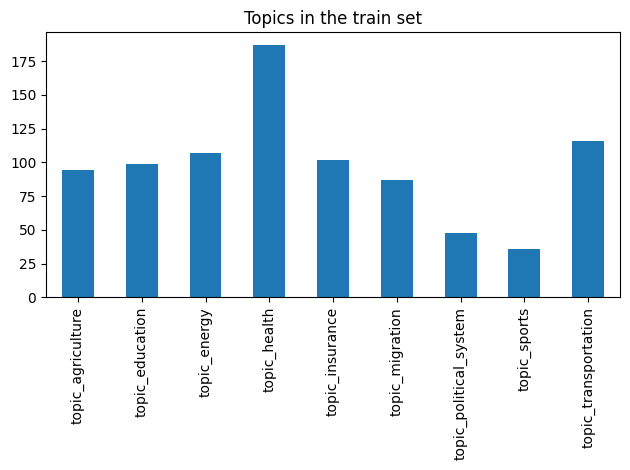

In [15]:
plotting.plot_and_log(
    df_input_train[topic_columns].sum().plot.bar,
    "data/train_topic_counts.png",
    title="Topics in the train set",
)

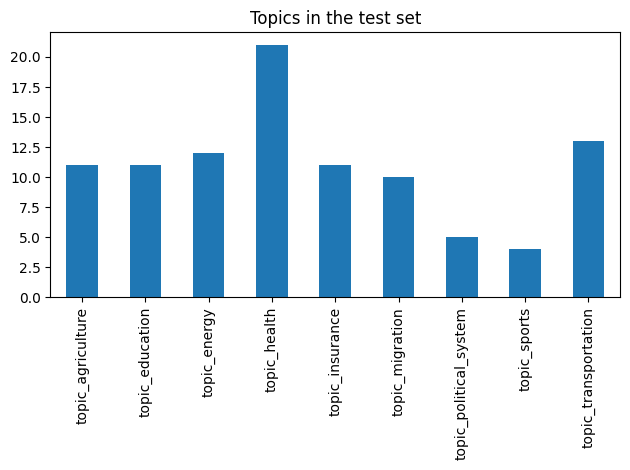

In [16]:
plotting.plot_and_log(
    df_input_test[topic_columns].sum().plot.bar,
    "data/test_topic_counts.png",
    title="Topics in the test set",
)

# Classification

In [17]:
X_train, y_train = demokratis_ml.models.consultation_topics.model.create_matrices(df_input_train, topic_columns)
X_test, y_test = demokratis_ml.models.consultation_topics.model.create_matrices(df_input_test, topic_columns)

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (732, 12288) (732, 9)
Test (80, 12288) (80, 9)


## CV

In [18]:
classifier_cv = demokratis_ml.models.consultation_topics.model.create_classifier(RANDOM_STATE)
classifier_cv

,steps,"[('standardscaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,400
,copy,True
,whiten,False
,svd_solver,'auto'


In [19]:
cv = iterstrat.ml_stratifiers.MultilabelStratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None, column_name: str = "") -> np.float64:
    """If PCA is used in the pipeline, include its explained variance in scores."""
    if (pca := demokratis_ml.models.consultation_topics.model.get_pca_step(pipeline)) is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


args = {
    "estimator": classifier_cv,
    "X": X_train,
    "y": y_train,
    "cv": cv,
    "verbose": 2,
    "n_jobs": -1,
}

print("cross_validate...")
cv_scores = sklearn.model_selection.cross_validate(
    **args,
    scoring={
        "precision": "precision_samples",
        "recall": "recall_samples",
        "f1": "f1_samples",
        **{
            f"pca_explained_variance_{c}": functools.partial(explained_variance_scorer, column_name=c)
            for c in (
                "embedding_consultation_title",
                "embedding_consultation_description",
                "embedding_documents",
                "organisation_uuid",
                "embeddings",
            )
        },
    },
)
display(cv_scores)

print("\ncross_val_predict...")
y_cv_predicted = sklearn.model_selection.cross_val_predict(**args)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no 

[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   3.0s
[CV] END .................................................... total time=   3.0s


{'fit_time': array([2.90445781, 2.82975698, 2.86015511, 2.94234371, 2.85419917]),
 'score_time': array([0.04656696, 0.05502295, 0.04816318, 0.0464592 , 0.05035591]),
 'test_precision': array([0.86206897, 0.90728477, 0.8707483 , 0.91438356, 0.86713287]),
 'test_recall': array([0.84942529, 0.88852097, 0.85487528, 0.89726027, 0.84265734]),
 'test_f1': array([0.84804598, 0.89050773, 0.85578231, 0.89497717, 0.84265734]),
 'test_pca_explained_variance_embedding_consultation_title': array([0.95340596, 0.9549727 , 0.9540905 , 0.95325439, 0.95361134]),
 'test_pca_explained_variance_embedding_consultation_description': array([0.95340596, 0.9549727 , 0.9540905 , 0.95325439, 0.95361134]),
 'test_pca_explained_variance_embedding_documents': array([0.95340596, 0.9549727 , 0.9540905 , 0.95325439, 0.95361134]),
 'test_pca_explained_variance_organisation_uuid': array([0.95340596, 0.9549727 , 0.9540905 , 0.95325439, 0.95361134]),
 'test_pca_explained_variance_embeddings': array([0.95340596, 0.9549727 , 


cross_val_predict...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


In [20]:
utils.log_metrics(**{k.replace("test_", "cv_"): np.mean(v) for k, v in cv_scores.items() if k.startswith("test_")})

{'cv_f1': 0.8664,
 'cv_pca_explained_variance_embedding_consultation_description': 0.9539,
 'cv_pca_explained_variance_embedding_consultation_title': 0.9539,
 'cv_pca_explained_variance_embedding_documents': 0.9539,
 'cv_pca_explained_variance_embeddings': 0.9539,
 'cv_pca_explained_variance_organisation_uuid': 0.9539,
 'cv_precision': 0.8843,
 'cv_recall': 0.8665}


cv_classification_report.txt

                        precision    recall  f1-score   support

     topic_agriculture       0.90      0.86      0.88        94
       topic_education       0.97      0.87      0.91        99
          topic_energy       0.97      0.88      0.92       107
          topic_health       0.90      0.78      0.84       187
       topic_insurance       0.95      0.91      0.93       102
       topic_migration       0.99      0.89      0.93        87
topic_political_system       0.95      0.88      0.91        48
          topic_sports       1.00      0.83      0.91        36
  topic_transportation       0.98      0.85      0.91       116

             micro avg       0.95      0.85      0.90       876
             macro avg       0.96      0.86      0.91       876
          weighted avg       0.95      0.85      0.90       876
           samples avg       0.96      0.87      0.87       876



/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


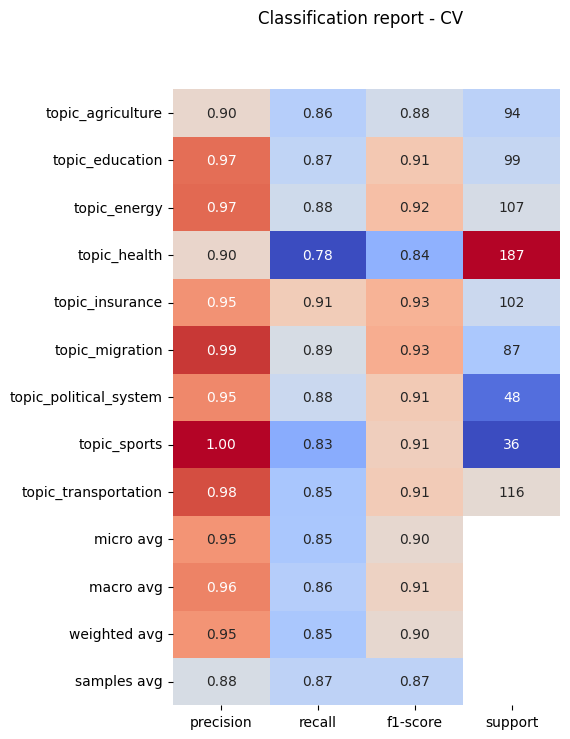

<Figure size 640x480 with 0 Axes>

In [21]:
utils.log_classification_report("cv", y_train, y_cv_predicted, target_names=topic_columns)
fig = plotting.plot_classification_report_heatmap(
    y_train.values,
    y_cv_predicted,
    target_names=topic_columns,
)
fig.suptitle("Classification report - CV")
plt.tight_layout()
mlflow.log_figure(fig, "cv_classification_report.png")
fig

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


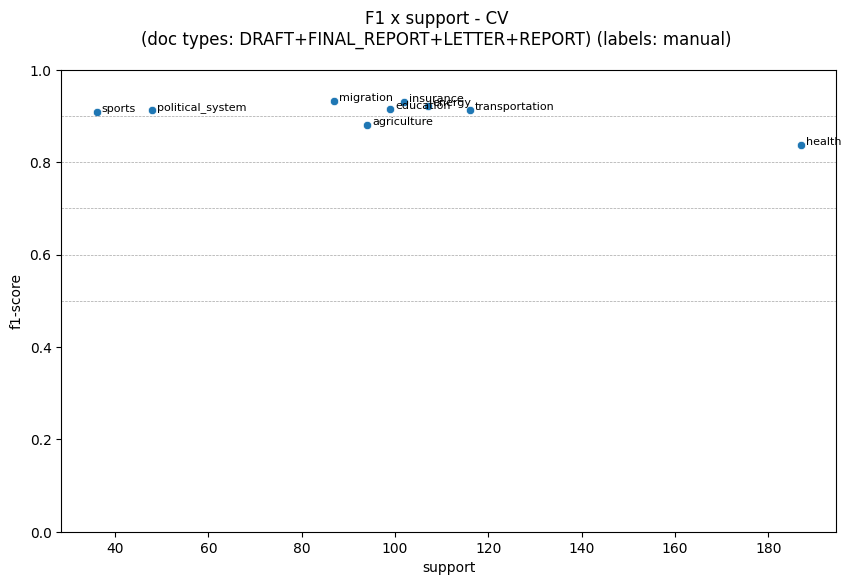

<Figure size 640x480 with 0 Axes>

In [22]:
fig = plotting.plot_score_against_support(
    y_train.values,
    y_cv_predicted,
    target_names=topic_columns,
)
document_types = "+".join(sorted(t if t else "unknown" for t in DOC_TYPES))
# label_sources = "+".join(sorted(df_input["consultation_topics_label_source"].unique()))
label_sources = "+".join(sorted(TOPIC_LABEL_SOURCES))
fig.suptitle(
    "\n".join(
        [
            "F1 x support - CV",
            f"(doc types: {document_types}) (labels: {label_sources})",
        ]
    )
)
plt.tight_layout()
mlflow.log_figure(fig, "cv_score_against_support.png")
fig

In [23]:
report = pd.DataFrame(
    sklearn.metrics.classification_report(
        y_train.values,
        y_cv_predicted,
        target_names=topic_columns,
        output_dict=True,
        zero_division=np.nan,
    )
).transpose()["f1-score"]
# Print a dict of F1 scores for each topic that can be used for ignoring topics (in the Setup section)
{topic.replace("topic_", ""): round(f1, 3) for topic, f1 in report.items() if topic.startswith("topic_")}

{'agriculture': 0.88,
 'education': 0.915,
 'energy': 0.922,
 'health': 0.837,
 'insurance': 0.93,
 'migration': 0.933,
 'political_system': 0.913,
 'sports': 0.909,
 'transportation': 0.912}

## Training

2025/07/24 16:08:06 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2025/07/24 16:08:09 WARNING mlflow.sklearn.utils: log_loss failed. The metric training_log_loss will not be recorded. Metric error: Found array with dim 3, while dim <= 2 is required.
2025/07/24 16:08:09 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: Found array with dim 3, while dim <= 2 is required.
2025/07/24 16:08:09 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: multilabel-indicator is not supported
2025/07/24 16:08:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


''

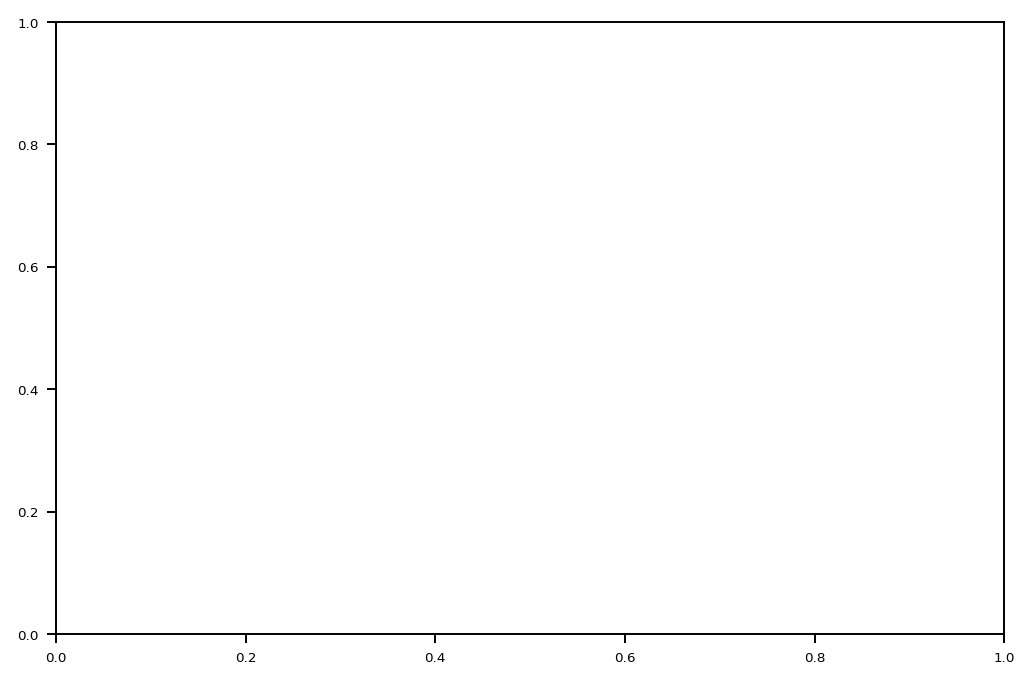

In [24]:
classifier_test = demokratis_ml.models.consultation_topics.model.create_classifier(RANDOM_STATE)
classifier_test.fit(X_train, y_train)
;

## Evaluation on the test set

In [25]:
y_test_predicted = classifier_test.predict(X_test)

precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    y_test,
    y_test_predicted,
    average="samples",
    zero_division=np.nan,
)
test_scores = {"test_precision": precision, "test_recall": recall, "test_f1": f1}
utils.log_metrics(**test_scores)

{'test_f1': 0.9083, 'test_precision': 0.9803, 'test_recall': 0.9}


test_classification_report.txt

                        precision    recall  f1-score   support

     topic_agriculture       0.90      0.82      0.86        11
       topic_education       0.90      0.82      0.86        11
          topic_energy       1.00      1.00      1.00        12
          topic_health       1.00      0.86      0.92        21
       topic_insurance       1.00      0.91      0.95        11
       topic_migration       1.00      1.00      1.00        10
topic_political_system       1.00      0.60      0.75         5
          topic_sports       1.00      0.75      0.86         4
  topic_transportation       1.00      0.92      0.96        13

             micro avg       0.98      0.88      0.92        98
             macro avg       0.98      0.85      0.91        98
          weighted avg       0.98      0.88      0.92        98
           samples avg       0.98      0.90      0.91        98



/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


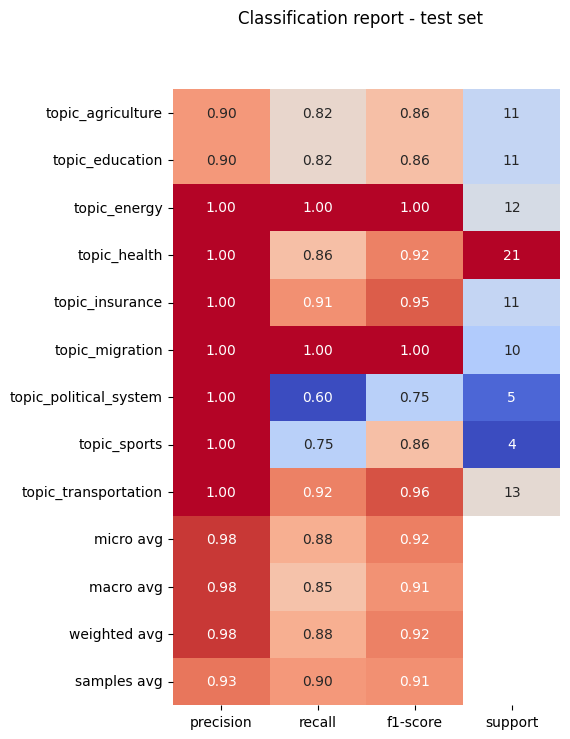

<Figure size 640x480 with 0 Axes>

In [26]:
utils.log_classification_report(
    "test",
    y_test,
    y_test_predicted,
    target_names=topic_columns,
)

fig = plotting.plot_classification_report_heatmap(
    y_test,
    y_test_predicted,
    target_names=topic_columns,
)
fig.suptitle("Classification report - test set")
mlflow.log_figure(fig, "test_classification_report.png")
plt.tight_layout()
display(fig)

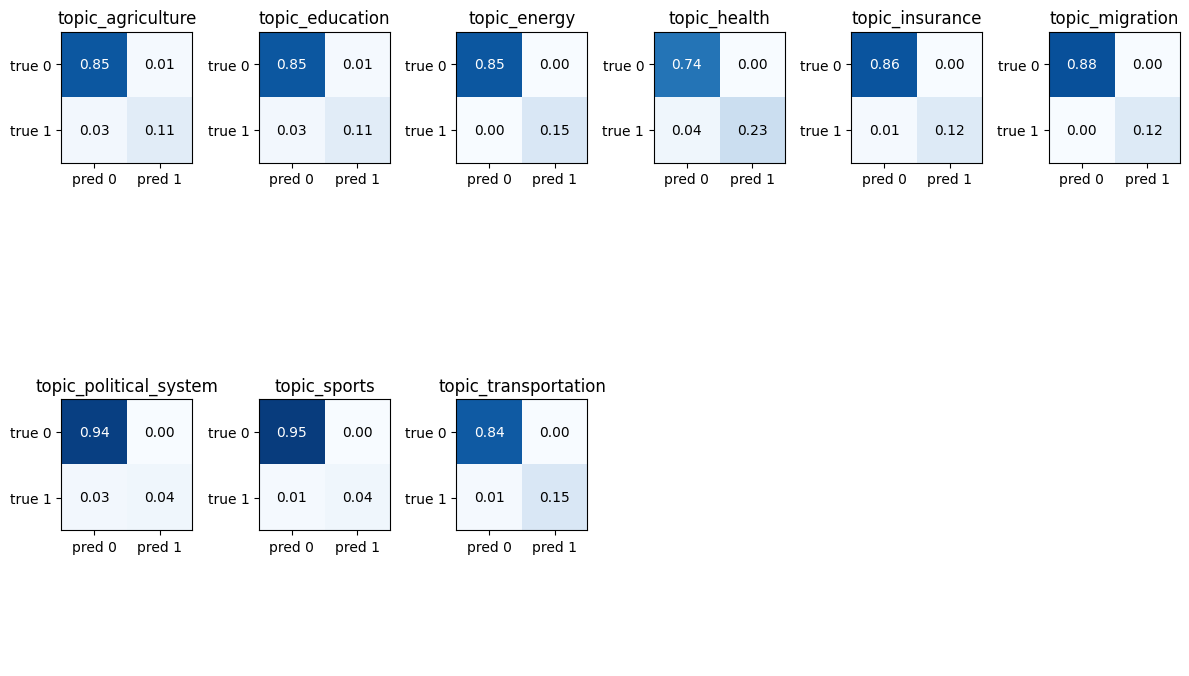

In [27]:
def plot_multilabel_confusion_matrices(Y_true: np.ndarray, Y_pred: np.ndarray, class_names: list[str]) -> None:
    """
    Plot confusion matrices (2x2) for each label as heatmaps.
    """
    cm_list = sklearn.metrics.multilabel_confusion_matrix(Y_true, Y_pred)
    n_classes = len(class_names)
    n_cols = 6
    n_rows = int(np.ceil(n_classes / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    axes = axes.flatten()

    for i, (cm, label) in enumerate(zip(cm_list, class_names, strict=True)):
        cm = cm / cm.sum()  # noqa: PLW2901
        # assert cm.sum() == 1.0

        ax = axes[i]
        ax.imshow(cm, interpolation="nearest", cmap="Blues", vmin=0, vmax=1)
        ax.set_title(label)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["pred 0", "pred 1"])
        ax.set_yticklabels(["true 0", "true 1"])

        # Annotate cells
        thresh = cm.max() / 2.0
        for j in range(2):
            for k in range(2):
                ax.text(
                    k,
                    j,
                    format(cm[j, k], ".2f"),
                    ha="center",
                    va="center",
                    color="white" if cm[j, k] > thresh else "black",
                )

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    plt.show()


plot_multilabel_confusion_matrices(y_test, y_test_predicted, class_names=topic_columns)

***

# End MLflow run

In [ ]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="consultation_topic_classifier",
# )

2025/07/24 16:12:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/07/24 16:12:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'consultation_topic_classifier'.
2025/07/24 16:12:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: consultation_topic_classifier, version 1
Created version '1' of model 'consultation_topic_classifier'.


In [ ]:
mlflow.end_run()

***

# Cleanlab

In [ ]:
RUN_CLEANLAB = False

In [ ]:
import cleanlab
import cleanlab.internal.multilabel_utils

from research.lib import cleanlab_analysis

if RUN_CLEANLAB:
    df_cleanlab = pd.concat([df_input_train, df_input_test], ignore_index=True)
    X_cleanlab, y_cleanlab = demokratis_ml.models.consultation_topics.model.create_matrices(df_cleanlab, topic_columns)
    print(X_cleanlab.shape)
    classifier_cleanlab = demokratis_ml.models.consultation_topics.model.create_classifier(RANDOM_STATE)
    pred_probs_list = sklearn.model_selection.cross_val_predict(
        estimator=classifier_cleanlab,
        X=X_cleanlab,
        y=y_cleanlab,
        cv=cv,
        method="predict_proba",
        n_jobs=-1,
        verbose=2,
    )
    pred_probs = demokratis_ml.models.consultation_topics.model.get_predicted_label_probabilities(pred_probs_list)
    print(pred_probs.shape)
    assert pred_probs.shape[0] == len(df_cleanlab)
    assert pred_probs.shape[1] == len(topic_columns)

In [ ]:
if RUN_CLEANLAB:
    labels = cleanlab.internal.multilabel_utils.onehot2int(y_cleanlab.values)
    lab = cleanlab.Datalab(
        data={
            "X": X_cleanlab,
            "labels": labels,
        },
        label_name="labels",
        task="multilabel",
    )
    lab.find_issues(pred_probs=pred_probs, features=X_cleanlab)
    lab.report()

In [ ]:
if RUN_CLEANLAB:
    df_output = df_cleanlab.copy()
    df_output = df_output[
        [
            "consultation_url",
            "consultation_title",
            "consultation_description",
            "organisation_name",
        ]
    ]
    true_labels = y_cleanlab.copy()
    true_labels.columns = [c.replace("topic_", "") for c in true_labels.columns]
    issue_dfs = cleanlab_analysis.cleanlab_issues_to_excel(
        lab,
        pred_probs=pred_probs,
        dataset=df_output,
        multilabel_true_labels=true_labels,
        output_path=f"cleanlab_issues_{DATA_VERSION}.xlsx",
        linkify_columns={
            "consultation_url",
        },
        issue_types=(
            "label",
            "near_duplicate",
            "outlier",
            # "underperforming_group",
            "non_iid",
        ),
    )